In [2]:
#install modules
!pip install pandas scikit-learn matplotlib seaborn
!pip install fuzzywuzzy
!pip install python-Levenshtein

#import modules
from IPython import get_ipython
from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from datetime import timedelta  # Import the timedelta object
import seaborn as sns
import matplotlib.pyplot as plt
from IPython import get_ipython
from IPython.display import display
from sklearn.linear_model import LogisticRegression
from rapidfuzz import fuzz, process, utils
import re
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

%matplotlib inline
sns.set()



%matplotlib inline
sns.set()


In [3]:
Athena = r"C:\Users\steph\OneDrive\Desktop\Athena.csv"
Athena = pd.read_csv(Athena)
Athena = pd.DataFrame(Athena)

In [24]:
Wells_Fargo = r"C:\Users\steph\OneDrive\Desktop\Wells_Fargo.csv"
Wells_Fargo = pd.read_csv(Wells_Fargo)
Wells_Fargo = pd.DataFrame(Wells_Fargo)

In [26]:
Athena.head()

,Journal Date,Type,Account,Account Description,Batch Date,Net Amount
0,12/31/2024,Credit Card,WLPR,"LAWSON WASH, PHR RECEIPT",12/1/2024,"$187,277.46"
1,12/31/2024,Credit Card,WLPR,"LAWSON WASH, PHR RECEIPT",12/2/2024,"$476,080.23"
2,12/31/2024,Credit Card,WLPR,"LAWSON WASH, PHR RECEIPT",12/3/2024,"$610,205.78"
3,12/31/2024,Credit Card,WLPR,"LAWSON WASH, PHR RECEIPT",12/4/2024,"$603,803.35"
4,12/31/2024,Credit Card,WLPR,"LAWSON WASH, PHR RECEIPT",12/5/2024,"$444,917.46"


In [27]:
Wells_Fargo.head()

,date date,Amount,Transaction detail,Submitted date
0,12/2/2024,"42,207.94",American,241129
1,12/2/2024,"2,948.00",American,241130
2,12/2/2024,"11,708.00",American,241201
3,12/2/2024,"13,733.86",Merchant,241202
4,12/2/2024,"37,995.00",Merchant,241203


In [28]:
Athena.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Journal Date         153 non-null    object
 1   Type                 152 non-null    object
 2   Account              152 non-null    object
 3   Account Description  152 non-null    object
 4   Batch Date           150 non-null    object
 5   Net Amount           153 non-null    object
dtypes: object(6)
memory usage: 7.3+ KB


In [29]:
Wells_Fargo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68 entries, 0 to 67
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   date date           68 non-null     object
 1   Amount              68 non-null     object
 2   Transaction detail  68 non-null     object
 3   Submitted date      68 non-null     int64 
dtypes: int64(1), object(3)
memory usage: 2.3+ KB


In [30]:
# Rename the "date date" column to "date"
Wells_Fargo = Wells_Fargo.rename(columns={"date date": "date"})
Athena = Athena.rename(columns={"Batch Date": "date"})

In [31]:
#Convert to datetime with the correct format
Wells_Fargo['date'] = pd.to_datetime(Wells_Fargo['date'], format='%m/%d/%Y', errors='raise').dt.date

Athena['date'] = pd.to_datetime(Athena['date'], format='%m/%d/%Y', errors='raise').dt.date


In [32]:
Wells_Fargo.head()


,date,Amount,Transaction detail,Submitted date
0,2024-12-02,"42,207.94",American,241129
1,2024-12-02,"2,948.00",American,241130
2,2024-12-02,"11,708.00",American,241201
3,2024-12-02,"13,733.86",Merchant,241202
4,2024-12-02,"37,995.00",Merchant,241203


In [33]:
Athena.head()

,Journal Date,Type,Account,Account Description,date,Net Amount
0,12/31/2024,Credit Card,WLPR,"LAWSON WASH, PHR RECEIPT",2024-12-01,"$187,277.46"
1,12/31/2024,Credit Card,WLPR,"LAWSON WASH, PHR RECEIPT",2024-12-02,"$476,080.23"
2,12/31/2024,Credit Card,WLPR,"LAWSON WASH, PHR RECEIPT",2024-12-03,"$610,205.78"
3,12/31/2024,Credit Card,WLPR,"LAWSON WASH, PHR RECEIPT",2024-12-04,"$603,803.35"
4,12/31/2024,Credit Card,WLPR,"LAWSON WASH, PHR RECEIPT",2024-12-05,"$444,917.46"


In [34]:
# Print actual column names for inspection
print("Columns in Wells_Fargo:", Wells_Fargo.columns)

# Function to find the "Amount" column, handling variations in naming
def find_amount_column(df):
    possible_names = ['Amount', 'amount', 'transaction amount', 'total amount',
                      'transaction_amount', 'total_amount',  # Added snake_case variations
                      ' Amount', 'amount ', 'Amount ']  # Added variations with spaces

    for name in possible_names:
        if name in df.columns:
            return name
    return None  # Return None if no suitable column is found

# Find the "Amount" column using the function
amount_column = find_amount_column(Wells_Fargo)

if amount_column:
    # Remove space after "Amount" if present
    if amount_column == 'Amount ':
        Wells_Fargo = Wells_Fargo.rename(columns={'Amount ': 'Amount'})
        amount_column = 'Amount'  # Update the amount_column variable

    print(f"Found '{amount_column}' column.")
else:
    print("Error: Could not find the Amount column. Please check your data and column names carefully.")


Columns in Wells_Fargo: Index(['date', 'Amount ', 'Transaction detail', 'Submitted date'], dtype='object')
Found 'Amount' column.


In [35]:
# Print actual column names for inspection
print("Columns in Wells_Fargo:", Athena.columns)

# Function to find the "Amount" column, handling variations in naming
def find_amount_column(df):
    possible_names = ['Amount', 'amount', 'transaction amount', 'total amount',
                      'transaction_amount', 'total_amount',  # Added snake_case variations
                      'Net Amount', 'amount ', 'Amount ']  # Added variations with spaces

    for name in possible_names:
        if name in df.columns:
            return name
    return None  # Return None if no suitable column is found

# Find the "Amount" column using the function
amount_column = find_amount_column(Athena)

if amount_column:
    # Remove space after "Amount" if present
    if amount_column == 'Net Amount':
        Athena = Athena.rename(columns={'Net Amount': 'Amount'})
        amount_column = 'Amount'  # Update the amount_column variable

    print(f"Found '{amount_column}' column.")
else:
    print("Error: Could not find the Amount column. Please check your data and column names carefully.")


Columns in Wells_Fargo: Index(['Journal Date', 'Type', 'Account', 'Account Description', 'date',
       'Net Amount'],
      dtype='object')
Found 'Amount' column.


In [36]:
def clean_currency(amount):
    """Removes currency symbols and commas from a string, and converts it to an integer."""
    # Convert to string first to handle floats and other data types
    amount = str(amount)
    # Remove any leading/trailing spaces, dollar signs, and commas
    cleaned_amount = amount.strip().replace('$', '').replace(',', '')

    try:
        # Attempt to convert to float
        return float(cleaned_amount)  # Convert to float first to handle decimals
    except ValueError:
        # Handle cases where conversion fails (e.g., non-numeric values)
        return None

# Apply the cleaning function to the 'Amount' column in Wells_Fargo
Wells_Fargo['Amount'] = Wells_Fargo['Amount'].apply(clean_currency)
Wells_Fargo['Amount'] = Wells_Fargo['Amount'].astype(float)

# Apply the cleaning function to the "Net Amount" column
Athena['Amount'] = Athena['Amount'].apply(clean_currency)
Athena['Amount'] = Athena['Amount'].astype(float)


In [37]:
Wells_Fargo.info()
Athena.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68 entries, 0 to 67
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                68 non-null     object 
 1   Amount              68 non-null     float64
 2   Transaction detail  68 non-null     object 
 3   Submitted date      68 non-null     int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 2.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Journal Date         153 non-null    object 
 1   Type                 152 non-null    object 
 2   Account              152 non-null    object 
 3   Account Description  152 non-null    object 
 4   date                 150 non-null    object 
 5   Amount               129 non-null    float64
dtypes: float64(1), object(5)
memory u

In [38]:
#Drop unnecessary columns
#Athena = Athena.drop(columns=['Journal Date', 'Account', 'Account Description'])

#Drop unnecessary rows
Athena = Athena[Athena['Type'] == 'Credit Card']
Athena = Athena.drop(Athena[Athena['Type'] != 'Credit Card'].index)


In [39]:
# Exclude the first 7 rows of Wells_Fargo
Wells_Fargo = Wells_Fargo.iloc[7:]

# Reset the index
Wells_Fargo = Wells_Fargo.reset_index(drop=True)

In [40]:
#Random Forest Dataset setup
def manual_labels(Athena):
    pass

In [41]:
def custom_match(athena_date, athena_amount, wells_fargo_data, minimum_amount=5000):
    """
    Matches a specific Athena transaction to Wells Fargo transactions
    containing "Merchant" and "American" in their descriptions.

    Args:
        athena_date: The date of the Athena transaction.
        athena_amount: The amount of the Athena transaction.
        wells_fargo_data: The Wells Fargo DataFrame.

    Returns:
        True if a match is found, False otherwise.
    """
    tolerance = 1
    date_range_start = athena_date - timedelta(days=10)  # 9 days before
    date_range_end = athena_date + timedelta(days=10)  # 9 days after

    # Filter Wells Fargo transactions based on date range and keywords
    wells_fargo_subset = wells_fargo_data[
        (wells_fargo_data['date'] >= date_range_start) &
        (wells_fargo_data['date'] <= date_range_end) &
        (wells_fargo_data['Transaction detail'].str.contains('Merchant|American', case=False))&
        (wells_fargo_data['Amount'] >= minimum_amount)
    ]

    # If no transactions found within the date range, return False
    if wells_fargo_subset.empty:
        return False

    # Iterate through potential combinations of "Merchant" and "American Express" transactions
    for i in range(len(wells_fargo_subset)):
        for j in range(i + 1, len(wells_fargo_subset)):
            # Check if the sum of amounts matches the Athena amount within tolerance
            if (
                abs(
                    wells_fargo_subset.iloc[i]['Amount']
                    + wells_fargo_subset.iloc[j]['Amount']
                    - athena_amount
                )
                <= tolerance
            ):
                # Check if one transaction contains "Merchant" and the other contains "American"
                if (
                    "Merchant" in wells_fargo_subset.iloc[i]['Transaction detail']
                    and "American" in wells_fargo_subset.iloc[j]['Transaction detail']
                ) or (
                    "American" in wells_fargo_subset.iloc[i]['Transaction detail']
                    and "Merchant" in wells_fargo_subset.iloc[j]['Transaction detail']
                ):
                    return True  # Match found

    return False  # No match found

In [42]:
def preprocess_description(desc):
    """
    Cleans and standardizes a transaction description.

    Args:
        desc (str): The raw transaction description.

    Returns:
        str: The cleaned description.
    """
    if not isinstance(desc, str):
        desc = str(desc)  # Convert to string if not already

    desc = desc.lower()
    desc = re.sub(r'[^\w\s]', '', desc)  # Remove punctuation
    desc = desc.strip()  # Remove extra whitespace

    # Handle abbreviations
    abbreviations = {
        'st': 'street',
        'co': 'company',
        'inc': 'incorporated',
        'ltd':'limited'
    }
    words = desc.split()
    desc = ' '.join([abbreviations.get(word, word) for word in words])

    return desc
def find_best_fuzzy_match(athena_desc, wells_fargo_descs, scorer=fuzz.WRatio, min_score=70):
    """
    Finds the best fuzzy match for an Athena description within a list of Wells Fargo descriptions.

    Args:
        athena_desc (str): The Athena transaction description.
        wells_fargo_descs (list of str): List of Wells Fargo transaction descriptions.
        scorer (function): The fuzzy matching algorithm to use.
        min_score (int): Minimum score to consider a match.

    Returns:
        tuple: The best matching Wells Fargo description and its similarity score.
    """
    if not wells_fargo_descs:  # Handle empty list
        return None, 0

    # Preprocess descriptions
    processed_athena_desc = preprocess_description(athena_desc)

    # Unpack all three values, but only keep best_match and score
    result = process.extractOne(processed_athena_desc, wells_fargo_descs, scorer=scorer, processor=preprocess_description)
    if result is None:
        return None, 0
    best_match, score, _ = result # the _ is used to drop the 3rd value which is the index.

    if score >= min_score:
        return best_match, score
    else:
        return None, 0

def compare_transactions_with_fuzzy_matching(row, Wells_Fargo, used_indices, amount_fuzzy_threshold = 80, min_fuzzy_score = 60, date_tolerance=10):
    """
    Compares transaction details from Athena with Wells_Fargo,
    using fuzzy matching for descriptions and amounts.

    Args:
        row: A single row from Athena.
        Wells_Fargo: The Wells Fargo DataFrame.
        used_indices: A set of used indices from Wells Fargo.
        date_tolerance: The number of days before and after to create the date range

    Returns:
        A tuple containing:
            - Match result ('Match', 'No Match', 'Not Valid Date Match', 'No Wells Fargo Data')
            - Verification flag (True if the match is verified, False otherwise)
            - Updated set of used indices
            - Matched subset (if any)
            - Confidence: Score
            - Variance
    """
    date_athena = row['date']
    amount_athena = row['Amount']
    description_athena = row.get('Description', '')  # Get 'Description' if it exists

    if pd.isnull(date_athena):
        return 'Not Valid Date Match', False, used_indices, None, 0, None

    # Determine the date range based on whether it's in a special range

    date_range_start = date_athena - timedelta(days=date_tolerance)
    date_range_end = date_athena + timedelta(days=date_tolerance)

    wells_fargo_subset = Wells_Fargo[
        (Wells_Fargo['date'] >= date_range_start) & (Wells_Fargo['date'] <= date_range_end)
    ]

    if wells_fargo_subset.empty:
        return 'No Wells Fargo Data', False, used_indices, None, 0, None

    wells_fargo_subset = wells_fargo_subset.sort_values('Amount')

    # Filter Wells_Fargo to exclude used indices
    wells_fargo_subset = wells_fargo_subset[~wells_fargo_subset.index.isin(used_indices)]

    # Sort by date
    wells_fargo_subset = wells_fargo_subset.sort_values('date')

    matched_subset = []

    # Helper function to handle matches
    def handle_match(indices, confidence):
        for index in indices:
            matched_subset.append(wells_fargo_subset.loc[index])
            used_indices.add(index)

        # Calculate variance based on matched transactions
        if len(matched_subset) == 1:
            variance = matched_subset[0]['Amount'] - amount_athena
        elif len(matched_subset) == 2:
            variance = (matched_subset[0]['Amount'] + matched_subset[1]['Amount']) - amount_athena
        else:
            variance = None
        return 'Match', True, used_indices, [pd.DataFrame(matched_subset)], confidence, variance

    # 1. Exact Match on Amount
    for index_i in wells_fargo_subset.index:
        if wells_fargo_subset.loc[index_i]['Amount'] == amount_athena:
            return handle_match([index_i], 100) #confidence = 100

    # 2. Exact Match on Two Transactions
    for index_i in wells_fargo_subset.index:
        for index_j in wells_fargo_subset.index:
            if index_j == index_i:
                continue
            if (wells_fargo_subset.loc[index_i]['Amount'] + wells_fargo_subset.loc[index_j]['Amount'] == amount_athena):
                return handle_match([index_i, index_j], 100) #confidence = 100

    # 3. Fuzzy Match on Description and Amount (if no exact amount match)
    if 'Transaction detail' in wells_fargo_subset.columns:
        wells_fargo_descriptions = wells_fargo_subset['Transaction detail'].tolist()
    else:
        wells_fargo_descriptions = []

    # 3a. Fuzzy Match on single description
    best_match, score = find_best_fuzzy_match(description_athena, wells_fargo_descriptions, min_score=min_fuzzy_score) #Lower score
    if best_match: #if there is a match
        match_index = wells_fargo_subset[wells_fargo_subset['Transaction detail'] == best_match].index
        if not match_index.empty:
            match_index = match_index[0]
            if fuzz.ratio(str(wells_fargo_subset.loc[match_index]['Amount']), str(amount_athena)) >= amount_fuzzy_threshold: #fuzzy match on amount
                confidence = (min_fuzzy_score + score)/2 #confidence score will be the average of the 2 scores.
                return handle_match([match_index], confidence)

     # 3b. Fuzzy Match on two descriptions
    for index_i in wells_fargo_subset.index:
        for index_j in wells_fargo_subset.index:
            if index_j == index_i:
                continue
            #check if sum is close to athena amount
            if fuzz.ratio(str(wells_fargo_subset.loc[index_i]['Amount'] + wells_fargo_subset.loc[index_j]['Amount']), str(amount_athena)) >= amount_fuzzy_threshold: #fuzzy match on amount
                #check if one of the descriptions is a fuzzy match
                best_match_i, score_i = find_best_fuzzy_match(description_athena, [wells_fargo_subset.loc[index_i]['Transaction detail']], min_score=min_fuzzy_score) #Lower score
                best_match_j, score_j = find_best_fuzzy_match(description_athena, [wells_fargo_subset.loc[index_j]['Transaction detail']], min_score=min_fuzzy_score) #Lower score
                if best_match_i or best_match_j:
                    confidence = (min_fuzzy_score + (score_i if score_i > score_j else score_j))/2 #confidence score will be the average of the min fuzzy score and the higher description score
                    return handle_match([index_i, index_j], confidence)


    return 'No Match', False, used_indices, None, 0, None

In [43]:
def prepare_data_for_ml(Athena, Wells_Fargo, match_results):
    """
    Prepares the data for training a machine learning model.
    """
    # Create a DataFrame from match_results
    match_results_df = pd.DataFrame(match_results)

    # Ensure 'Athena Data' is a dictionary in match_results_df
    match_results_df['Athena Data'] = match_results_df['Athena Data'].apply(lambda x: x if isinstance(x, dict) else {})

    # Extract Athena Amount and Description
    match_results_df['Athena Amount'] = match_results_df['Athena Data'].apply(lambda x: x.get('Amount', None))
    match_results_df['Description'] = match_results_df['Athena Data'].apply(lambda x: x.get('Description', ''))

    # Handle cases where 'Description' key might be missing
    if 'Description' not in match_results_df.columns:
        match_results_df['Description'] = ''

    # Inspect descriptions
    print("Sample Descriptions before TF-IDF:")
    print(match_results_df['Description'].head())
    print("-" * 40)
    # Handle empty descriptions by providing a default value
    match_results_df['Description'] = match_results_df['Description'].apply(lambda x: x if x != "" else "no description")

    # Check for empty descriptions before TF-IDF
    if match_results_df['Description'].empty:
        print("Error: Description column is empty. Check the data and preprocessing steps.")
        return None, None, None, None, None, None, None, None  # Return None values to signal an error

    # Add a 'Match' label (1 for match, 0 for no match)
    match_results_df['Match'] = match_results_df.apply(lambda row: 1 if row['Match Result'] == 'Match' or row['Match Found'] == 'Custom Match' else 0, axis=1)

    # Only proceed if there are matches or non matches.
    if match_results_df['Match'].sum() == 0 and (len(match_results_df) - match_results_df['Match'].sum()) == 0:
        print("Error: No matches or non-matches were found. Check the data and matching logic.")
        return None, None, None, None, None, None, None, None

    # Feature Engineering:
    # Numerical features (Amount)
    numerical_features = ['Athena Amount']
    X_numerical = match_results_df[numerical_features]

    # Text features (Description) using TF-IDF
    tfidf_vectorizer = TfidfVectorizer(max_features=500)
    X_text = tfidf_vectorizer.fit_transform(match_results_df['Description'])
    X_text = pd.DataFrame(X_text.toarray(), columns=[f'text_feature_{i}' for i in range(X_text.shape[1])])

    # Combine numerical and text features
    X = pd.concat([X_numerical, X_text], axis=1)
    y = match_results_df['Match']

    # --- NaN handling ---
    # Check for NaNs before imputation
    print(f"Number of NaN values before imputation: {X.isna().sum().sum()}")
    # Impute NaNs
    imputer = SimpleImputer(strategy='mean')
    X = imputer.fit_transform(X)
    print(f"Number of NaN values after imputation: {pd.DataFrame(X).isna().sum().sum()}")
    # Re-assign the correct columns to the dataframe
    X = pd.DataFrame(X, columns=pd.concat([X_numerical, X_text], axis=1).columns)


    # Data Scaling
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

    # Data Splitting
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

    return X_train, X_val, X_test, y_train, y_val, y_test, scaler, tfidf_vectorizer

# Function to train matching model
def train_matching_model(X_train, y_train, X_val, y_val):
    """
    Trains a logistic regression model for matching transactions.
    """
    # Model selection
    model = RandomForestClassifier(random_state=42)

    # Model tuning (example: try different numbers of trees)
    param_grid = {'n_estimators': [100, 200, 300]} # you can add more parameters here to tune.
    grid_search = GridSearchCV(model, param_grid, cv=3)
    grid_search.fit(X_train, y_train)
    model = grid_search.best_estimator_ # Use best model

    # Model Evaluation
    y_pred = model.predict(X_val)
    print(f"Validation accuracy: {accuracy_score(y_val, y_pred)}")
    print(classification_report(y_val, y_pred))

    return model
    # Model training
    model.fit(X_train, y_train)


# Function to predict a match
def predict_match(model, scaler, athena_transaction, wells_fargo_transaction, tfidf_vectorizer):
    """
    Predicts whether two transactions are a match.
    """
    # If the scaler is None or the model is None, return None.
    if scaler is None or model is None:
        return None

    # Feature extraction for athena_transaction
    athena_amount = athena_transaction.get('Amount', 0)
    description = athena_transaction.get('Description', '')

    # Create features for the transactions
    X_new_numerical = pd.DataFrame({'Athena Amount': [athena_amount]})
    X_new_text = tfidf_vectorizer.transform([description])
    X_new_text = pd.DataFrame(X_new_text.toarray(), columns=[f'text_feature_{i}' for i in range(X_new_text.shape[1])])

    # Combine features
    X_new = pd.concat([X_new_numerical, X_new_text], axis=1)

    # Align column names with the training data
    train_columns = [col for col in X_train.columns if col in X_new.columns]

    # Only use the training columns.
    X_new = X_new[train_columns]

    # Scale the new data
    X_new_scaled = scaler.transform(X_new)

    # Predict the match
    prediction = model.predict(X_new_scaled)
    return prediction[0] == 1



In [44]:
#Initialize a list to store the results
match_results = []

#Initialize a set to store used indices (outside the loop)
used_indices = set()

# Set the desired date tolerance (in days)
date_tolerance = 10  # Allow for a 9-day variance

# Iterate through Athena transactions
for index, row in Athena.iterrows():
    athena_date = row['date']
    athena_amount = row['Amount']

    # First, try to find a match using custom_match
    match_found = custom_match(athena_date, athena_amount, Wells_Fargo)

    if match_found:
        match_results.append({
            'Athena Index': index,
            'Athena Date': athena_date,
            'Athena Amount': athena_amount,
            'Match Found': 'Custom Match', # Indicate that it's a custom match
            'Verification Passed': 'True'  # Custom Match is assumed to be verfied
        })
    else:
        # If custom_match fails, use compare_transactions_with_fuzzy_matching as a fallback
        result, verification_passed, used_indices, matched_subset, confidence, variance = compare_transactions_with_fuzzy_matching(row, Wells_Fargo, used_indices, date_tolerance=date_tolerance)

        match_results.append({
            'Athena Index': index,
            'Athena Data': row.to_dict(),
            'Match Result': result,
            'Verification Passed': verification_passed,
            'Used Indices': used_indices.copy(),
            'Matched Subset': matched_subset,
            'Match Type': 'Compare Transactions with fuzzy matching', # Indicate that it's from compare_transactions
            'Confidence': confidence,
            'Variance': variance
        })

# Prepare data for ML, train model and make predictions outside of loop
X_train, X_val, X_test, y_train, y_val, y_test, scaler, tfidf_vectorizer = prepare_data_for_ml(Athena, Wells_Fargo, match_results)
# Only proceed if there is data in match_results
if match_results:
    X_train, X_val, X_test, y_train, y_val, y_test, scaler, tfidf_vectorizer = prepare_data_for_ml(Athena, Wells_Fargo, match_results)
    # Only proceed if scaler was set
    if scaler is not None:
        model = train_matching_model(X_train, y_train, X_val, y_val)
    else:
        model = None
else:
    scaler = None
    model = None

# Sample a few transactions from Athena for manual labeling
np.random.seed(42)  # For reproducibility
num_samples = 5  # Number of samples to select
num_samples = min(num_samples, len(Athena)) # Set this to the correct amount
athena_indices_to_label = np.random.choice(Athena.index, size=num_samples, replace=False)

# Create the manual_labels DataFrame
manual_labels = pd.DataFrame({
    'athena_index': athena_indices_to_label,
    'wells_fargo_index': [None] * num_samples,  # Initially set to None
    'athena_transaction': [None] * num_samples,
    'wells_fargo_transaction': [None] * num_samples,
    'label': [None] * num_samples,  # Placeholder for manual labels
})

# --- 2. Prepare Athena Transactions in the manual_labels dataframe ---
for index, row in manual_labels.iterrows():
    athena_index = row['athena_index']
    athena_transaction = Athena.loc[athena_index].to_dict() # Gets the transaction for that index
    manual_labels.at[index, 'athena_transaction'] = athena_transaction #Add the transaction to the dataframe.

# --- 3. Manual Labeling ---
# This is where you would manually label the 'label' column (0 or 1)
# and assign the correct 'wells_fargo_index' for matches (or leave it as NaN for no matches).
# You might present the Athena and Wells Fargo data side-by-side in a separate tool or interface.
# For the sake of this example, let's create some dummy labels.
# Create dummy data for the test data.
# Find a subset of wells_fargo data to assign to the indices.
wells_fargo_indices = np.random.choice(Wells_Fargo.index, size=num_samples, replace=True)
for index, row in manual_labels.iterrows():
    if np.random.rand() > 0.5: # Make this more or less than 0.5 to see the differences.
        manual_labels.at[index, 'label'] = 1 #Assign it as a match
        manual_labels.at[index, 'wells_fargo_index'] = wells_fargo_indices[index] #Assign a wells fargo index
    else:
        manual_labels.at[index, 'label'] = 0 #Assign as no match
        manual_labels.at[index, 'wells_fargo_index'] = np.nan # Assign it to nan

# Populate the 'wells_fargo_transaction' column for matches
for index, row in manual_labels.iterrows():
    if row['label'] == 1:  # Check if it's a match
        wells_fargo_index = row['wells_fargo_index']
        if pd.notnull(wells_fargo_index):  # Check if the index is not NaN
            wells_fargo_transaction = Wells_Fargo.loc[wells_fargo_index].to_dict()
            manual_labels.at[index, 'wells_fargo_transaction'] = wells_fargo_transaction

# --- 4. Prepare Features (Similar to prepare_data_for_ml) ---

#Create a function to create the new data
def prepare_unseen_data(manual_labels, Athena, Wells_Fargo, tfidf_vectorizer = None, scaler = None, imputer = None):
    """
    Prepares the manually labeled data for training a machine learning model.
    """
    # Check that the manual labels are either 0 or 1.
    if manual_labels['label'].sum() == 0 and (len(manual_labels) - manual_labels['label'].sum()) == 0:
        print("Error: No matches or non-matches were found. Check the data and matching logic.")
        return None, None, None, None, None, None, None, None
    # Feature Engineering:
    # Numerical features (Amount)
    numerical_features = ['Athena Amount']

    #Prepare the athena dataframe for feature creation.
    manual_labels['Athena Amount'] = manual_labels['athena_transaction'].apply(lambda x: x.get('Amount', None))
    # Handle cases where 'Description' key might be missing
    manual_labels['Description'] = manual_labels['athena_transaction'].apply(lambda x: x.get('Description', ''))

    # Check for empty descriptions before TF-IDF
    if manual_labels['Description'].empty:
        print("Error: Description column is empty. Check the data and preprocessing steps.")
        return None, None, None, None, None, None, None, None  # Return None values to signal an error

    # Handle empty descriptions by providing a default value
    manual_labels['Description'] = manual_labels['Description'].apply(lambda x: x if x != "" else "no description")

    X_numerical = manual_labels[numerical_features]

    # Text features (Description) using TF-IDF
    if tfidf_vectorizer is None:
        tfidf_vectorizer = TfidfVectorizer(max_features=500)
        X_text = tfidf_vectorizer.fit_transform(manual_labels['Description'])
    else:
        X_text = tfidf_vectorizer.transform(manual_labels['Description'])

    X_text = pd.DataFrame(X_text.toarray(), columns=[f'text_feature_{i}' for i in range(X_text.shape[1])])

    # Combine numerical and text features
    X = pd.concat([X_numerical, X_text], axis=1)
    y = manual_labels['label']

    # --- NaN handling ---
    # Check for NaNs before imputation
    print(f"Number of NaN values before imputation: {X.isna().sum().sum()}")
    # Impute NaNs
    if imputer is None:
        imputer = SimpleImputer(strategy='mean')
        X = imputer.fit_transform(X)
    else:
        X = imputer.transform(X)

    print(f"Number of NaN values after imputation: {pd.DataFrame(X).isna().sum().sum()}")
    # Re-assign the correct columns to the dataframe
    X = pd.DataFrame(X, columns=pd.concat([X_numerical, X_text], axis=1).columns)

    # Data Scaling
    if scaler is None:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
    else:
        X_scaled = scaler.transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

    # Data Splitting
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    X_train

# Print the results
for result in match_results:
    print(result)

Sample Descriptions before TF-IDF:
0    
1    
2    
3    
4    
Name: Description, dtype: object
----------------------------------------
Number of NaN values before imputation: 5
Number of NaN values after imputation: 0
Sample Descriptions before TF-IDF:
0    
1    
2    
3    
4    
Name: Description, dtype: object
----------------------------------------
Number of NaN values before imputation: 5
Number of NaN values after imputation: 0
Validation accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         1

    accuracy                           1.00         7
   macro avg       1.00      1.00      1.00         7
weighted avg       1.00      1.00      1.00         7

{'Athena Index': 0, 'Athena Date': datetime.date(2024, 12, 1), 'Athena Amount': 187277.46, 'Match Found': 'Custom Match', 'Verification Passed': 'True'}
{'Athena Index': 1, 'Athena Date': datetime.date(20

In [45]:
# Select the first row of athena and wells fargo to use as an example.
athena_example = Athena.iloc[0].to_dict()
wells_fargo_example = Wells_Fargo.iloc[0].to_dict()

# Predict whether they match using our trained ML model
# Check that the model and scaler are not None before we use them.
if model is not None and scaler is not None:
    prediction = predict_match(model, scaler, athena_example, wells_fargo_example, tfidf_vectorizer)

    # Show prediction to the user.
    if prediction:
        print("The model predicts that these transactions are a match.")
    else:
        print("The model predicts that these transactions are not a match.")
else:
    print("Model or Scaler is None. Unable to make prediction.")

The model predicts that these transactions are a match.


C:\Users\steph\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [46]:
for result in match_results:
            print(result)

{'Athena Index': 0, 'Athena Date': datetime.date(2024, 12, 1), 'Athena Amount': 187277.46, 'Match Found': 'Custom Match', 'Verification Passed': 'True'}
{'Athena Index': 1, 'Athena Date': datetime.date(2024, 12, 2), 'Athena Amount': 476080.23, 'Match Found': 'Custom Match', 'Verification Passed': 'True'}
{'Athena Index': 2, 'Athena Date': datetime.date(2024, 12, 3), 'Athena Amount': 610205.78, 'Match Found': 'Custom Match', 'Verification Passed': 'True'}
{'Athena Index': 3, 'Athena Data': {'Journal Date': '12/31/2024', 'Type': 'Credit Card', 'Account': 'WLPR', 'Account Description': 'LAWSON WASH, PHR RECEIPT', 'date': datetime.date(2024, 12, 4), 'Amount': 603803.35}, 'Match Result': 'No Match', 'Verification Passed': False, 'Used Indices': set(), 'Matched Subset': None, 'Match Type': 'Compare Transactions with fuzzy matching', 'Confidence': 0, 'Variance': None}
{'Athena Index': 4, 'Athena Data': {'Journal Date': '12/31/2024', 'Type': 'Credit Card', 'Account': 'WLPR', 'Account Descripti

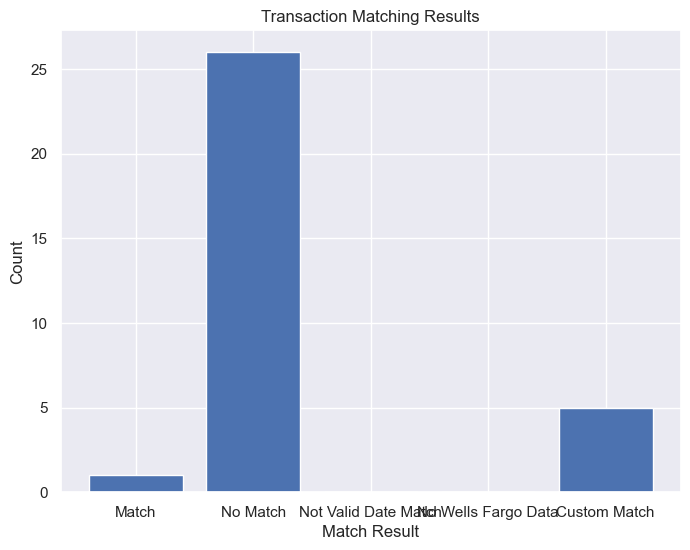

Matched Transactions:
----------------------------------------
Athena:
  Athena Index: 0
  Athena Date: 2024-12-01
  Athena Amount: 187277.46
  Match Found: Custom Match
  Verification Passed: True
Wells Fargo:
----------------------------------------
Athena:
  Athena Index: 1
  Athena Date: 2024-12-02
  Athena Amount: 476080.23
  Match Found: Custom Match
  Verification Passed: True
Wells Fargo:
----------------------------------------
Athena:
  Athena Index: 2
  Athena Date: 2024-12-03
  Athena Amount: 610205.78
  Match Found: Custom Match
  Verification Passed: True
Wells Fargo:
----------------------------------------
Athena:
  Athena Index: 8
  Athena Date: 2024-12-09
  Athena Amount: 643860.31
  Match Found: Custom Match
  Verification Passed: True
Wells Fargo:
----------------------------------------
Athena:
  Journal Date: 12/31/2024
  Type: Credit Card
  Account: WLPR
  Account Description: LAWSON WASH, PHR RECEIPT
  date: 2024-12-22
  Amount: 150657.57
Wells Fargo:
  date: 20

In [47]:
# Visualization 1: Bar chart of matches and non-matches
import matplotlib.pyplot as plt

match_counts = {'Match': 0, 'No Match': 0, 'Not Valid Date Match': 0, 'No Wells Fargo Data': 0, 'Custom Match': 0} #Add 'Custom Match' to the dict
for result in match_results:  # Changed results to match_results
    if 'Match Result' in result: #if Match Result is in the dict.
        match_counts[result['Match Result']] += 1
    elif 'Match Found' in result: #if Match Found is in the dict.
        match_counts['Custom Match'] +=1

plt.figure(figsize=(8, 6))
plt.bar(match_counts.keys(), match_counts.values())
plt.xlabel("Match Result")
plt.ylabel("Count")
plt.title("Transaction Matching Results")
plt.show()

# Visualization 2: Table of matched transactions (if any)
matched_transactions = []
for result in match_results:  # Changed results to match_results
    if result.get('Match Result') == 'Match' or result.get('Match Found') == 'Custom Match': #if the result has 'Match Result' as a key and the value is 'Match' or if it has 'Match Found' and the value is 'Custom Match'
        if result.get('Match Result') == 'Match':
            athena_data = result['Athena Data']
            # Check if 'Matched Subset' is not None and is a list
            if result['Matched Subset'] is not None and isinstance(result['Matched Subset'], list):
                # Assuming 'Matched Subset' is a list of DataFrames, access the first one
                wells_fargo_data = result['Matched Subset'][0].to_dict('records')
            else:
                wells_fargo_data = []  # Or handle the case differently if needed
        else:
            athena_data = {
            'Athena Index': result['Athena Index'],
            'Athena Date': result['Athena Date'],
            'Athena Amount': result['Athena Amount'],
            'Match Found': result['Match Found'],
            'Verification Passed': result['Verification Passed']
        }
            wells_fargo_data = []  # Or handle the case differently if needed

        matched_transactions.append({
            'Athena Transaction': athena_data,
            'Wells Fargo Transactions': wells_fargo_data
        })

if matched_transactions:
    print("Matched Transactions:")
    for transaction in matched_transactions:
        print("-" * 40)
        print("Athena:")
        for k, v in transaction['Athena Transaction'].items():
            print(f"  {k}: {v}")
        print("Wells Fargo:")
        for wf_transaction in transaction['Wells Fargo Transactions']:
            for k, v in wf_transaction.items():
                print(f"  {k}: {v}")
else:
    print("No matches found.")

In [48]:
# Extract no matches from match_results
no_matches = [result for result in match_results if result.get('Match Result') == 'No Match']

# Print no matches
if no_matches:
    print("No matches found for the following Athena transactions:")
    for no_match in no_matches:
        print("-" * 40)
        print("Athena:")
        for k, v in no_match['Athena Data'].items():
            print(f"  {k}: {v}")
else:
    print("All Athena transactions have matches.")

No matches found for the following Athena transactions:
----------------------------------------
Athena:
  Journal Date: 12/31/2024
  Type: Credit Card
  Account: WLPR
  Account Description: LAWSON WASH, PHR RECEIPT
  date: 2024-12-04
  Amount: 603803.35
----------------------------------------
Athena:
  Journal Date: 12/31/2024
  Type: Credit Card
  Account: WLPR
  Account Description: LAWSON WASH, PHR RECEIPT
  date: 2024-12-05
  Amount: 444917.46
----------------------------------------
Athena:
  Journal Date: 12/31/2024
  Type: Credit Card
  Account: WLPR
  Account Description: LAWSON WASH, PHR RECEIPT
  date: 2024-12-06
  Amount: 247628.34
----------------------------------------
Athena:
  Journal Date: 12/31/2024
  Type: Credit Card
  Account: WLPR
  Account Description: LAWSON WASH, PHR RECEIPT
  date: 2024-12-07
  Amount: 466675.25
----------------------------------------
Athena:
  Journal Date: 12/31/2024
  Type: Credit Card
  Account: WLPR
  Account Description: LAWSON WASH, 

In [49]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer

# Filter Athena for Credit Card transactions (using 'Type' column)
athena_credit_card = Athena[Athena['Type'] == 'Credit Card']

# 1. Prepare Data
athena_features = Athena[['Amount', 'date']]
wells_fargo_features = Wells_Fargo[['Amount', 'date']]

# 3. TF-IDF for Descriptions (using filtered Athena data)
vectorizer = TfidfVectorizer(max_features=100)
athena_tfidf = vectorizer.fit_transform(athena_credit_card['Type'])  # Using 'Description' column for TF-IDF
wells_fargo_tfidf = vectorizer.transform(Wells_Fargo['Transaction detail'])

# 4. Combine Features
athena_features = pd.concat([athena_features, pd.DataFrame(athena_tfidf.toarray())], axis=1)
wells_fargo_features = pd.concat([wells_fargo_features, pd.DataFrame(wells_fargo_tfidf.toarray())], axis=1)

# 5. Scale Data
scaler = StandardScaler()
athena_features_scaled = scaler.fit_transform(athena_features[['Amount']]) # Scale numerical features
wells_fargo_features_scaled = scaler.transform(wells_fargo_features[['Amount']])

# Combine scaled numerical features with TF-IDF features (if used)
if 'athena_tfidf' in locals():
    athena_features_final = pd.concat([pd.DataFrame(athena_features_scaled), pd.DataFrame(athena_tfidf.toarray())], axis=1)
    wells_fargo_features_final = pd.concat([pd.DataFrame(wells_fargo_features_scaled), pd.DataFrame(wells_fargo_tfidf.toarray())], axis=1)
else:
    athena_features_final = pd.DataFrame(athena_features_scaled)
    wells_fargo_features_final = pd.DataFrame(wells_fargo_features_scaled)


# 6. Apply K-means
k = 5  # Choose an appropriate number of clusters
kmeans_athena = KMeans(n_clusters=k, random_state=0)
athena_clusters = kmeans_athena.fit_predict(athena_features_final)

kmeans_wells_fargo = KMeans(n_clusters=k, random_state=0)
wells_fargo_clusters = kmeans_wells_fargo.fit_predict(wells_fargo_features_final)

# 7. Add Cluster Labels to DataFrames
Athena['cluster'] = athena_clusters
Wells_Fargo['cluster'] = wells_fargo_clusters

C:\Users\steph\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\steph\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


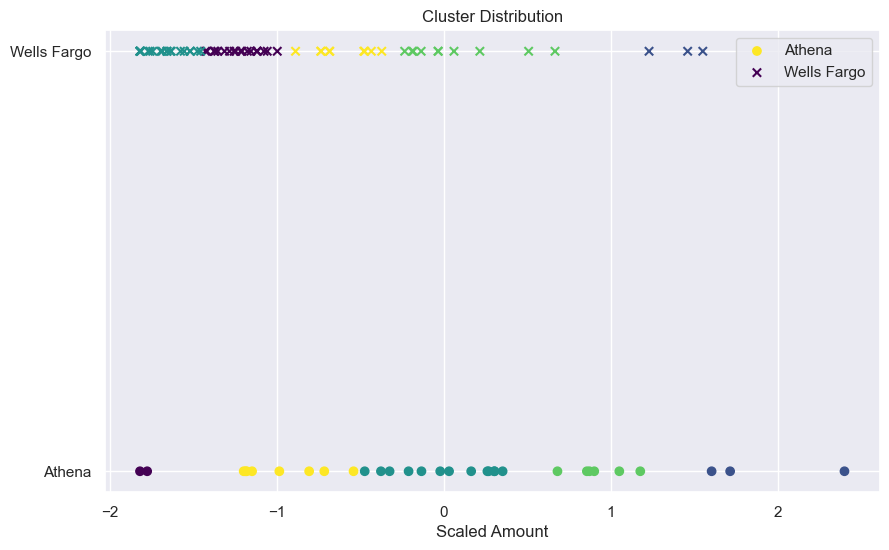

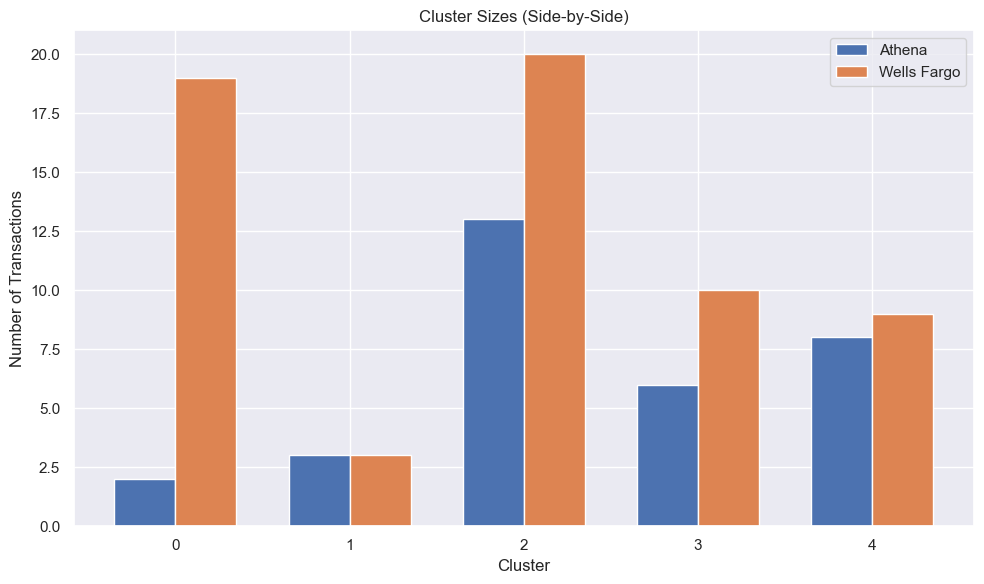

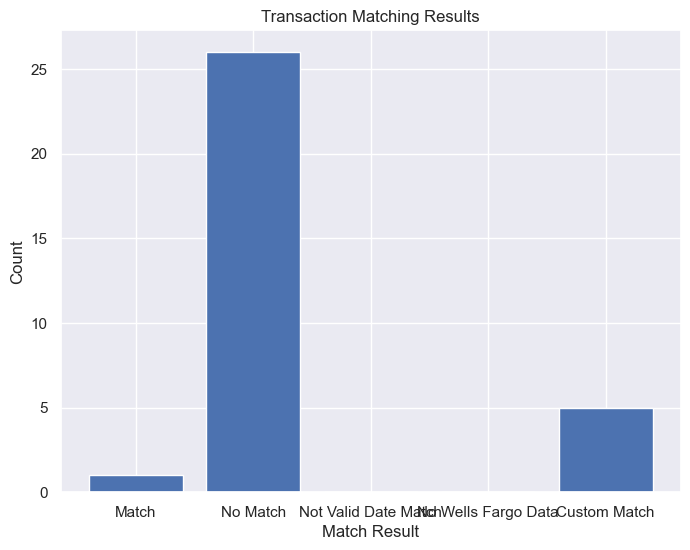

In [50]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns


# Visualization 1: Cluster Distribution (Scatter Plot)
# scaled features in 'athena_features_scaled' and 'wells_fargo_features_scaled'
plt.figure(figsize=(10, 6))
# If you scaled only 'Amount', use index 0 for x-axis
plt.scatter(athena_features_scaled[:, 0], [0] * len(athena_features_scaled),
            c=Athena['cluster'], cmap='viridis', marker='o', label='Athena')
plt.scatter(wells_fargo_features_scaled[:, 0], [1] * len(wells_fargo_features_scaled),
            c=Wells_Fargo['cluster'], cmap='viridis', marker='x', label='Wells Fargo')
plt.xlabel("Scaled Amount")
plt.yticks([0, 1], ['Athena', 'Wells Fargo'])
plt.title("Cluster Distribution")
plt.legend()
plt.show()

# Visualization 2: Cluster Sizes (Bar Chart)
athena_cluster_counts = Athena['cluster'].value_counts().sort_index()
wells_fargo_cluster_counts = Wells_Fargo['cluster'].value_counts().sort_index()

# Ensure both series have the same clusters
all_clusters = sorted(list(set(athena_cluster_counts.index) | set(wells_fargo_cluster_counts.index)))
athena_cluster_counts = athena_cluster_counts.reindex(all_clusters, fill_value=0)
wells_fargo_cluster_counts = wells_fargo_cluster_counts.reindex(all_clusters, fill_value=0)

plt.figure(figsize=(10, 6))

bar_width = 0.35
index = np.arange(len(all_clusters))  # Use all_clusters for the range

# Athena bars
plt.bar(index, athena_cluster_counts.values, bar_width, label='Athena')

# Wells Fargo bars, shifted by bar_width
plt.bar(index + bar_width, wells_fargo_cluster_counts.values, bar_width, label='Wells Fargo')

plt.xlabel("Cluster")
plt.ylabel("Number of Transactions")
plt.title("Cluster Sizes (Side-by-Side)")
plt.xticks(index + bar_width / 2, all_clusters)  # Place labels in the middle of the two bars
plt.legend()
plt.tight_layout() #prevent labels from overlapping
plt.show()

# Visualization 3: Matching Results (if you have 'match_results')
match_counts = {'Match': 0, 'No Match': 0, 'Not Valid Date Match': 0, 'No Wells Fargo Data': 0, 'Custom Match': 0} #Add 'Custom Match' to the dict
for result in match_results:  # Corrected: Changed 'results' to 'match_results'
    if 'Match Result' in result: #if Match Result is in the dict.
        match_counts[result['Match Result']] += 1
    elif 'Match Found' in result: #if Match Found is in the dict.
        match_counts['Custom Match'] +=1

plt.figure(figsize=(8, 6))
plt.bar(match_counts.keys(), match_counts.values())
plt.xlabel("Match Result")
plt.ylabel("Count")
plt.title("Transaction Matching Results")
plt.show()

In [51]:
# 1. Cluster Statistics:

def analyze_cluster(df, cluster_column='cluster'):
    """Calculates statistics for each cluster in a DataFrame."""
    cluster_stats = df.groupby(cluster_column).agg({
        'Amount': ['mean', 'std', 'min', 'max', 'count']
    })
    return cluster_stats

athena_cluster_stats = analyze_cluster(Athena)
wells_fargo_cluster_stats = analyze_cluster(Wells_Fargo)

print("Athena Cluster Statistics:")
print(athena_cluster_stats)
print("\nWells Fargo Cluster Statistics:")
print(wells_fargo_cluster_stats)

# 2. Cluster Comparison:

def compare_clusters(athena_df, wells_fargo_df, cluster_column='cluster'):
    """Compares cluster statistics between Athena and Wells Fargo."""
    athena_stats = athena_df.groupby(cluster_column)['Amount'].describe()
    wells_fargo_stats = wells_fargo_df.groupby(cluster_column)['Amount'].describe()

    comparison = pd.concat([athena_stats, wells_fargo_stats], axis=1, keys=['Athena', 'Wells Fargo'])
    return comparison

cluster_comparison = compare_clusters(Athena, Wells_Fargo)
print("\nCluster Comparison:")
print(cluster_comparison)

# 3. Transaction Distribution within Clusters:

def transactions_in_cluster(df, cluster_num, cluster_column='cluster'):
    """Prints transactions within a specific cluster."""
    cluster_transactions = df[df[cluster_column] == cluster_num]
    return cluster_transactions

# Example: Print transactions in cluster 0 for Athena
cluster_0_athena = transactions_in_cluster(Athena, 0)
print("\nAthena Transactions in Cluster 0:")
print(cluster_0_athena)

# 4. Outlier Detection (z-score method):

def find_outliers(df, column='Amount', threshold=3):
    """Identifies outliers using z-scores."""
    z_scores = np.abs((df[column] - df[column].mean()) / df[column].std())
    outliers = df[z_scores > threshold]
    return outliers

athena_outliers = find_outliers(Athena)
wells_fargo_outliers = find_outliers(Wells_Fargo)

print("\nAthena Outliers:")
print(athena_outliers)
print("\nWells Fargo Outliers:")
print(wells_fargo_outliers)

Athena Cluster Statistics:
                Amount                                          
                  mean           std        min        max count
cluster                                                         
0          4963.500000   6812.973837     146.00    9781.00     2
1        835579.690000  96629.716739  767815.92  946229.77     3
2        410604.599231  65017.890426  301928.43  487141.48    13
3        615157.278333  38436.686899  560790.16  672010.53     6
4        190575.493750  56941.043675  139397.37  286929.99     8

Wells Fargo Cluster Statistics:
                Amount                                          
                  mean           std        min        max count
cluster                                                         
0        133272.843158  28677.609453   88155.88  184500.60    19
1        725135.563333  37214.633585  683798.99  755972.17     3
2         33263.911000  27602.888568      44.99   81595.82    20
3        422520.316000  69142.

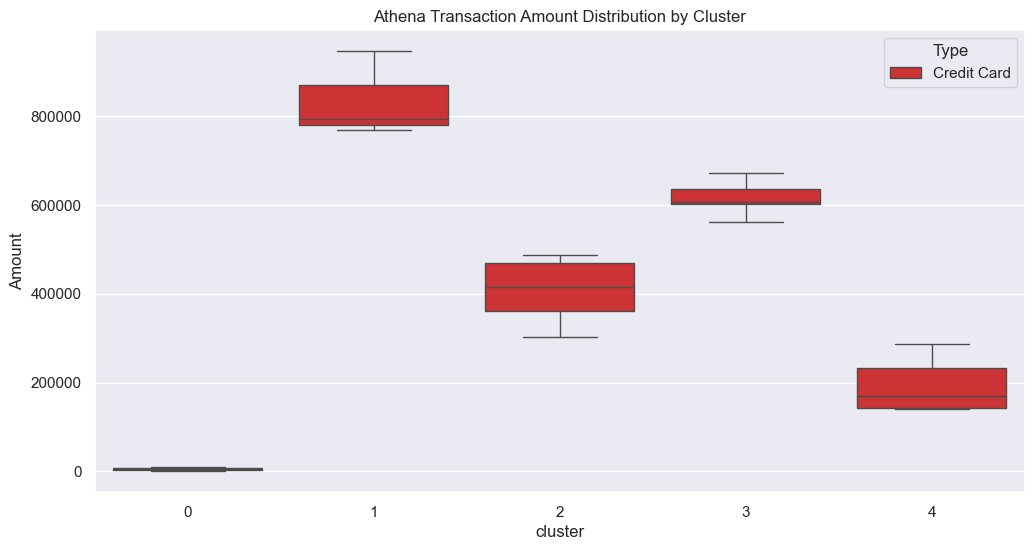

C:\Users\steph\AppData\Local\Temp\ipykernel_12604\945294819.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y='Amount', data=Wells_Fargo, palette='Set2')


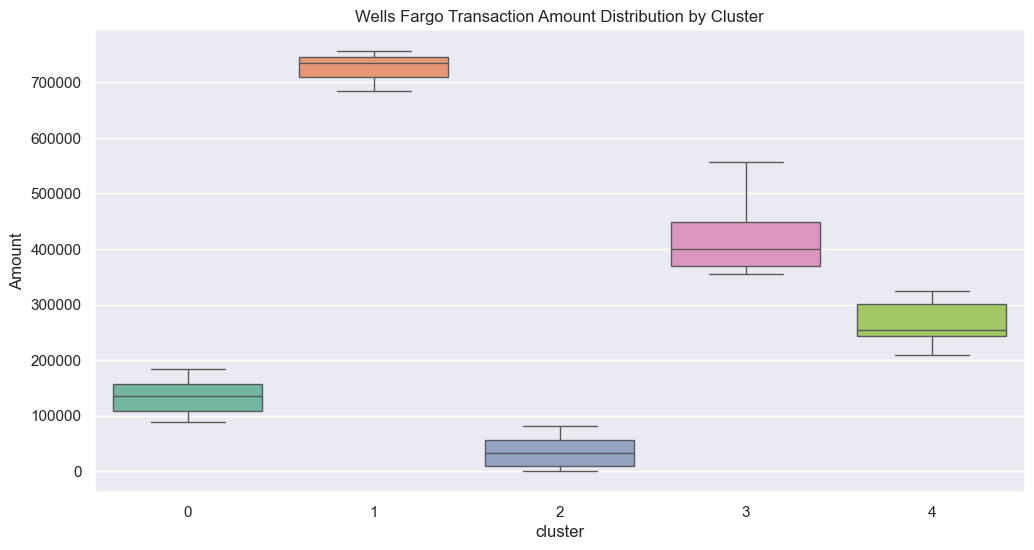

In [52]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='cluster', y='Amount', data=Athena, hue='Type', palette='Set1')  # Use 'Type' if available for color coding
plt.title('Athena Transaction Amount Distribution by Cluster')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='cluster', y='Amount', data=Wells_Fargo, palette='Set2')
plt.title('Wells Fargo Transaction Amount Distribution by Cluster')
plt.show()